In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import HoltWintersResults

### FLOW:

This study examines the dataset that reveals information on number of women murdered each year (per 100,000 standard population) in the United States. A time-series analysis will be conducted and I am after a successful ARIMA model to make effective predictions. 

In [2]:
wmurder_df=pd.read_csv('wmurders.csv').set_index('Unnamed: 0')

In [3]:
y = wmurder_df['x']

### Let's plot the data first:

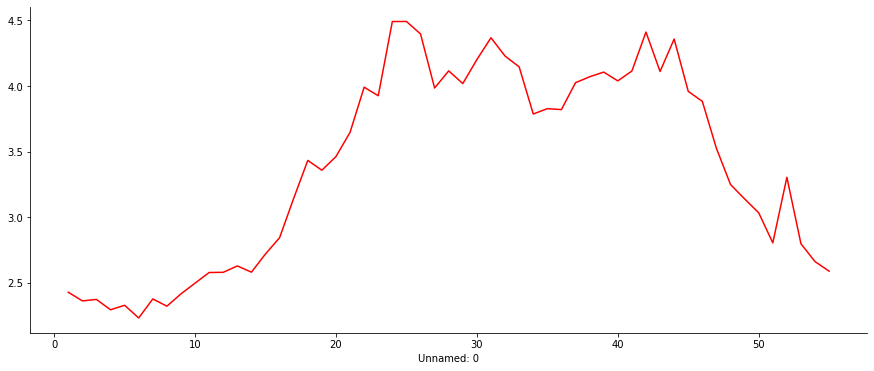

In [103]:
fig, ax= plt.subplots(figsize=(15,6))
y.plot(color="red",ax=ax)
sns.despine()
plt.show()

### By examining autocorrelations & partial autocorrelations, we can detect the best approach to solve this problem:

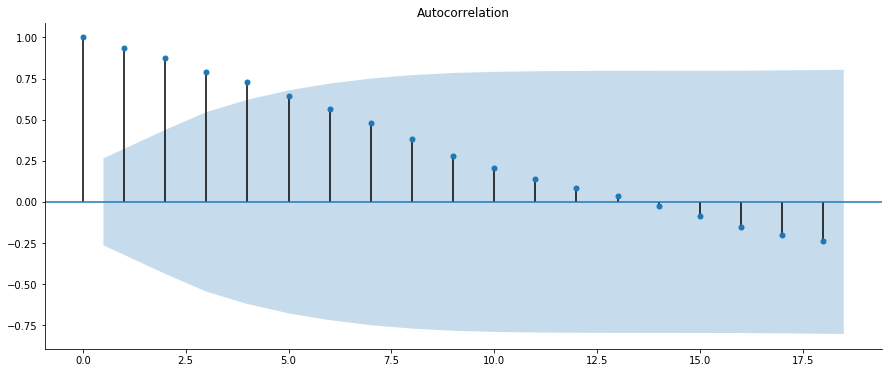

In [104]:
fig,ax = plt.subplots(figsize=(15,6))
sm.graphics.tsa.plot_acf(y, ax=ax)
sns.despine()
plt.show()

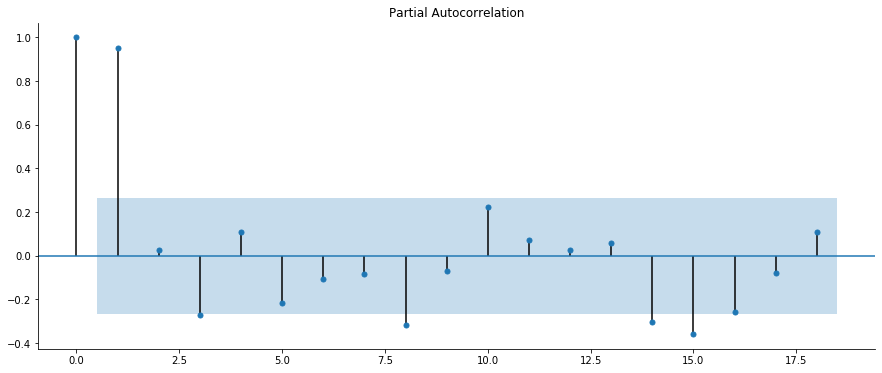

In [105]:
fig,ax = plt.subplots(figsize=(15,6))
sm.graphics.tsa.plot_pacf(y, ax=ax)
sns.despine()
plt.show()

##### Examination trend/seasonality:

There seems to be no seasonality in the data, however, we cannot disregard the trend in the dataset. Also, no consistent variation change is observed. Therefore, I did not use any transformation. Let's start with 1-lag differencing:

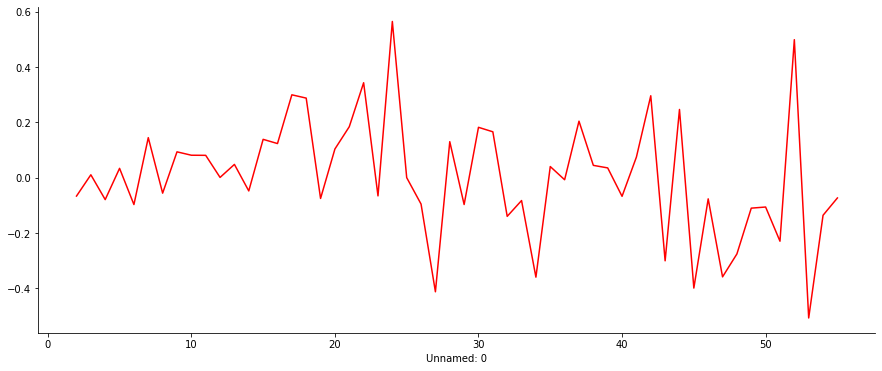

In [106]:
diff1 = (y-y.shift(1)).dropna()

fig,ax = plt.subplots(figsize=(15,6))
diff1.plot(color="red",ax=ax)
sns.despine()
plt.show()

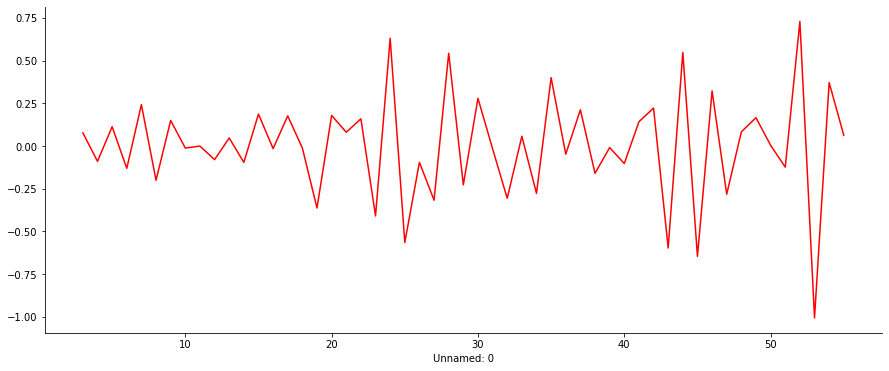

In [112]:
diff2 = (diff1-diff1.shift(1)).dropna()

fig,ax = plt.subplots(figsize=(15,6))
diff2.plot(color="red",ax=ax)
sns.despine()
plt.show()

##### Differencing seems to make data stationary, let's check it statistically.

In [127]:
sm.tsa.stattools.kpss(diff1)

C:\Users\okana\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1709: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.3251472654465792,
 0.1,
 11,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [128]:
sm.tsa.stattools.kpss(diff2)

C:\Users\okana\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1709: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.11258560828106058,
 0.1,
 11,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

##### Although differencing 1 time seems to be enough, there is a small downward trend, 2 times differentiation works perfectly and since we will transform the results back, I used 2 time differenced data:

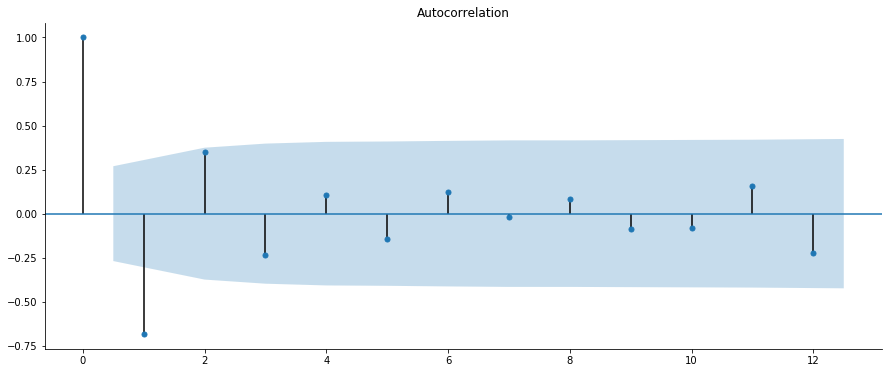

In [129]:
fig,ax = plt.subplots(figsize=(15,6))
sm.graphics.tsa.plot_acf(diff2, ax=ax,lags=12)
sns.despine()
plt.show()

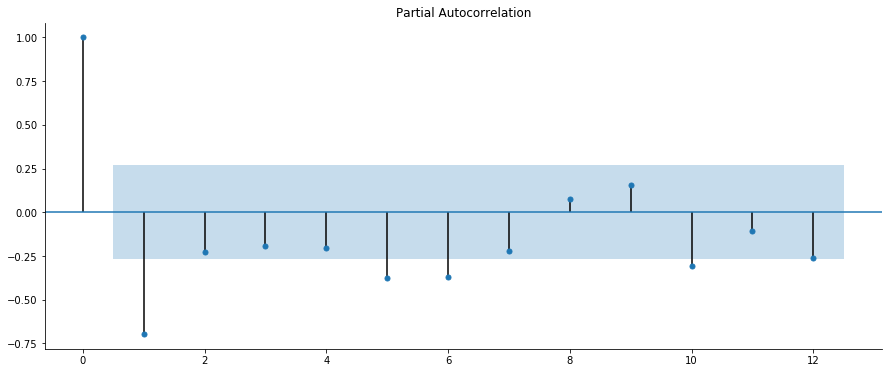

In [130]:
fig,ax = plt.subplots(figsize=(15,6))
sm.graphics.tsa.plot_pacf(diff2, ax=ax,lags=12)
sns.despine()
plt.show()

##### Ignoring lag-0 from python implementation, both ACF and PACF spike at lag-1 and seems to be dying out. From PACF, I determine AR terms a 1, and from ACF I determine MA term as 1, so the model is ARIMA(1,2,1):

I do not add a constant since no drift is observed.

(1-ϕ1B) * (1-B)^2 * (yt) = (1+θ1B) * εt

In [17]:
def calculate_aicc(model):
    comp1 = model.aic 
    comp2 = 2*(model.df_model)*(model.df_model+1)
    comp3 = model.nobs-model.df_model-1
    result = comp1 -(comp2/comp3)
    return result

In [144]:
arima1 = sm.tsa.ARIMA(y, order=(1, 2, 1)).fit(trend='nc')
print(arima1.summary())
print("sigma squared is estimated as:",round(arima1.sigma2,3))
print("AICc is estimated as:",round(calculate_aicc(arima1),3))

                             ARIMA Model Results                              
Dep. Variable:                   D2.x   No. Observations:                   53
Model:                 ARIMA(1, 2, 1)   Log Likelihood                   6.440
Method:                       css-mle   S.D. of innovations              0.211
Date:                Sat, 16 Jan 2021   AIC                             -6.880
Time:                        08:07:21   BIC                             -0.969
Sample:                             2   HQIC                            -4.607
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D2.x    -0.2434      0.155     -1.568      0.123      -0.548       0.061
ma.L1.D2.x    -0.8261      0.114     -7.228      0.000      -1.050      -0.602
                                    Roots           

C:\Users\okana\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\okana\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


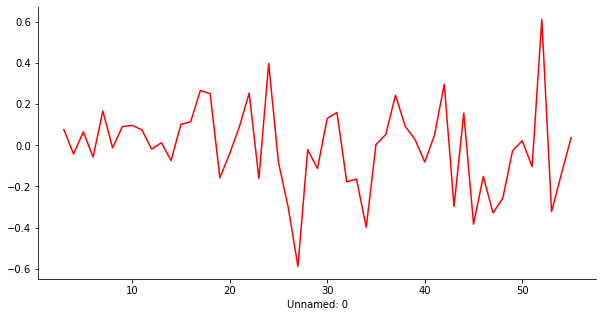

In [146]:
fig, ax= plt.subplots(figsize=(10,5))
arima1.resid.plot(color="red",ax=ax)
sns.despine()
plt.show()

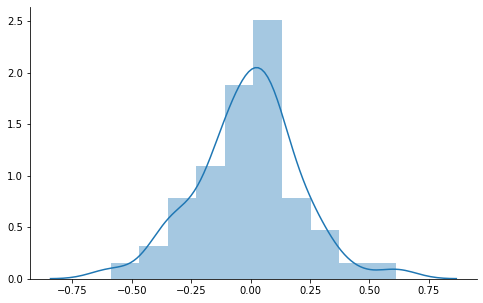

In [147]:
fig, ax= plt.subplots(figsize=(8,5))
sns.distplot(arima1.resid, ax=ax)
sns.despine()
plt.show()

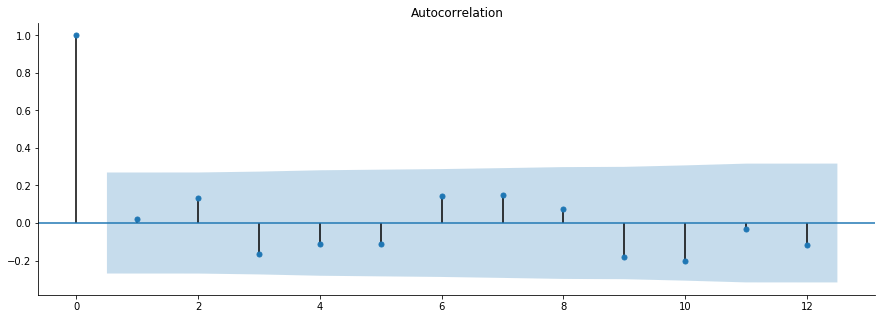

In [148]:
fig, ax = plt.subplots(figsize=(15,5))
sm.graphics.tsa.plot_acf(arima1.resid,lags=12, ax=ax)
sns.despine()
plt.show()

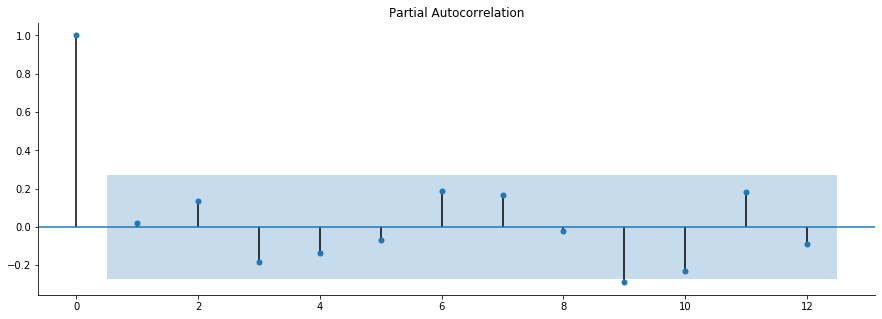

In [149]:
fig, ax = plt.subplots(figsize=(15,5))
sm.graphics.tsa.plot_pacf(arima1.resid,lags=12, ax=ax)
sns.despine()
plt.show()

#### The residuals are normally distributed, and no significant autocorrelation/ partial autocorrelation is observed.

In [150]:
arima1.forecast(steps=3,alpha=0.05)

(array([2.47066211, 2.36310978, 2.25283851]),
 array([0.21112587, 0.28838194, 0.3731042 ]),
 array([[2.05686302, 2.8844612 ],
        [1.79789156, 2.92832801],
        [1.52156771, 2.98410931]]))

#### Using the backshift operator, lets first get last 3 values and residuals from the data and model:

In [152]:
y[-3:]

Unnamed: 0
53    2.797697
54    2.662227
55    2.589383
Name: x, dtype: float64

In [154]:
arima1.resid[-3:]

Unnamed: 0
53   -0.322832
54   -0.140345
55    0.037079
dtype: float64

In [156]:
y_t_minus_1 = 2.589383
y_t_minus_2 = 2.662227
y_t_minus_3 = 2.797697

err_t_minus_1 = 0.037079

In [157]:
yt = 1.7566*(y_t_minus_1)-0.5132*(y_t_minus_2)-0.2434*(y_t_minus_3)-0.8261*(err_t_minus_1)
et = 0

yt_plus_1 = 1.7566*(yt)-0.5132*(y_t_minus_1)-0.2434*(y_t_minus_2)-0.8261*(et)
e_t_plus_1 = 0

yt_plus_2 = 1.7566*(yt_plus_1)-0.5132*(yt)-0.2434*(y_t_minus_1)-0.8261*(e_t_plus_1)

print(yt,yt_plus_1,yt_plus_2)

2.4706648696999998 2.36311250271502 2.252842388939164


#### My calculations from the backshift operator and the model forecasts are exactly the same:

C:\Users\okana\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\okana\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


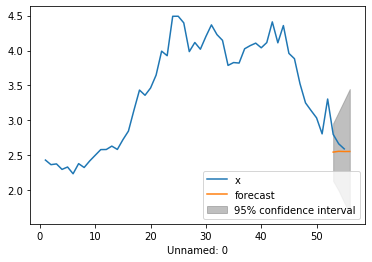

In [160]:
fig, ax = plt.subplots()
ax = y.plot(ax=ax)
fig = arima1.plot_predict(55, 58, dynamic=True, ax=ax, plot_insample=False)
plt.show()

In [4]:
from pmdarima.arima import auto_arima

arima2=auto_arima(y,seasonal=False)
arima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   55
Model:               SARIMAX(2, 2, 1)   Log Likelihood                   7.559
Date:                Sat, 16 Jan 2021   AIC                             -7.118
Time:                        19:09:28   BIC                              0.763
Sample:                             0   HQIC                            -4.088
                                 - 55                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1247      0.134     -0.930      0.352      -0.388       0.138
ar.L2          0.2348      0.159      1.479      0.139      -0.076       0.546
ma.L1         -0.9082      0.084    -10.785      0.000      -1.073      -0.743
sigma2         0.0426      0.009      4.633      0.000       0.025       0.061
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.95   Prob(JB):                         0.90
Heteroskedasticity (H):               4.53   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

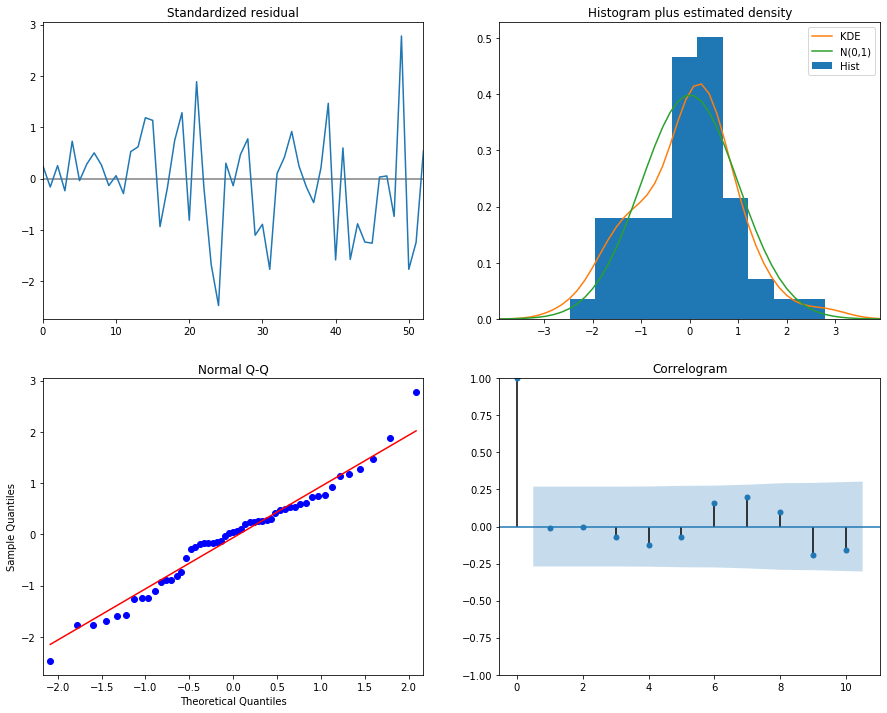

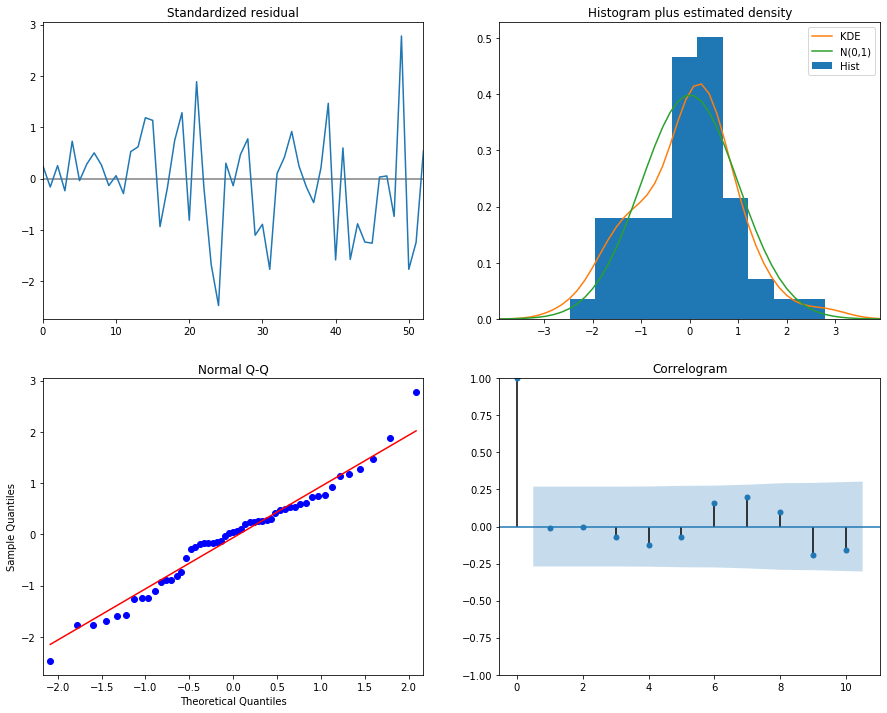

In [5]:
arima2.plot_diagnostics(figsize=(15, 12))

#### The results are similar but auto-selected model is better. ARIMA(2,2,1)